In [17]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [28]:
def synthetic_data(w: torch.Tensor, b: int, num_examples: int) -> torch.Tensor:
    """生成y=Xw+b+噪声
    
    Args:
        w (torch.Tensor): 权重
        b (int): 偏执量
        num_examples (int): 生成样本个数
    Returns:
        torch.Tensor:(特征，标签)
    """
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape(-1, 1)


true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
features[0],labels[0]

(tensor([1.0682, 0.1039]), tensor([5.9724]))

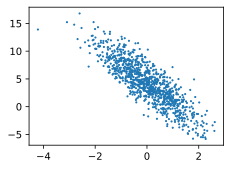

In [19]:
d2l.set_figsize()
d2l.plt.scatter(features[:,1].detach().numpy(),labels.detach().numpy(),s=1.5)

In [20]:
def data_iter(batch_size:int,features:torch.Tensor,labels:torch.Tensor):
  """_summary_
  Args:
      batch_size (int): 批量大小
      features (torch.Tensor): 样本
      labels (torch.Tensor): 标签

  Yields:
      _type_:迭代器
  """
  num_examples = len(features)
  indices = list(range(num_examples))
  random.shuffle(indices)
  for i in range(0,num_examples,batch_size):
    batch_indices = torch.tensor(
      indices[i:min(i+batch_size,num_examples)]
    )
    yield features[batch_indices],labels[batch_indices]
  

In [21]:
batch_size = 10
for X,y in data_iter(batch_size,features,labels):
  print(X, '\n', y)
  break

tensor([[ 0.3762, -0.9919],
        [ 2.2743, -0.1955],
        [-0.1679,  0.5532],
        [-2.4436, -0.7521],
        [-0.5079,  1.8357],
        [ 0.0751,  0.6842],
        [ 0.5672, -0.3696],
        [-1.1501,  1.5209],
        [-0.4088, -0.3815],
        [ 0.4543, -0.2614]]) 
 tensor([[ 8.3229],
        [ 9.4087],
        [ 1.9647],
        [ 1.8521],
        [-3.0581],
        [ 2.0525],
        [ 6.5883],
        [-3.2684],
        [ 4.6764],
        [ 5.9899]])


In [22]:
# 初始化参数
w = torch.normal(0,0.01,(2,1),requires_grad=True)
b = torch.zeros(1,requires_grad=True)

In [23]:
# 定义模型
def linreg(X,w,b):
  return torch.matmul(X,w)+b

In [24]:
# 定义损失
def squared_loss(y_hat:torch.Tensor,y:torch.Tensor):
  # TODO 为什么要reshape?
  return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2
  # return (y_hat - y) ** 2 / 2

In [25]:

from typing import List
def sgd(params:List[torch.Tensor],lr: float,batch_size: int):
  """小批量梯度下降

  Args:
      params (List[torch.Tensor]): 权重和偏置量
      lr (float): 学习率(超参数)
      batch_size (int): 样本规模
  """
  # 这里with的作用是什么? 更新的时候不参与梯度计算
  with torch.no_grad():
    for param in params:
      # 是对y.sum进行反向传播所以需要除以 batch_size计算平均梯度
      param -= lr * param.grad / batch_size
      param.grad.zero_()

In [26]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
  for X,y in data_iter(batch_size,features,labels):
    l = loss(net(X,w,b),y)
    l.sum().backward()
    sgd([w,b],lr,batch_size)
  with torch.no_grad():
    train_l = loss(net(features,w,b),labels)
    print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.034693
epoch 2, loss 0.000127


epoch 3, loss 0.000050


In [27]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-0.0005,  0.0006], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0004], grad_fn=<RsubBackward1>)
